In [65]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import torch 
import torchvision
from PIL import Image
import json
import datetime
from torchvision.transforms import transforms 
from torchvision.utils import make_grid
import torch.nn as nn
import time
import os
import copy
import torchvision.models as models
from torchvision.utils import save_image
import torch.nn.functional as F

from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


In [66]:
# local data_dir 
# data_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNet"
data_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/"
model_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models_2.0/"
# train/val/test dir CHANGE TO 64 or 255
data_file_path = data_dir + "/preprocessed_data/train_64_noreroofs_bias.npy"
test_data_file_path = data_dir + "/preprocessed_data/test_64_noreroofs.npy"
val_data_file_path = data_dir + "/preprocessed_data/val_64_noreroofs.npy"

In [67]:
import sys
sys.path.append("/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/roofnet/utils")
from data import ImageDataset

In [68]:
# import Roofnet
# from Roofnet.utils.data import ImageDataset
from torchvision.transforms import transforms 


transform_chain = transforms.Compose([
                        transforms.ToPILImage(mode='RGB'),
                        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0),
                        transforms.ToTensor(),
                        transforms.Normalize([0.,0.,0,], [1.,1.,1.]),   
                        
                            ])
data = ImageDataset(data_file_path,
                    transform=transform_chain)
dataloader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)
len(data), len(dataloader)


Loading data
Done loading data
Length 1050
Num Roofs 150


(1050, 33)

In [69]:
sample = data[0]  # get a sample from the dataset
print(type(sample))
print(len(sample))  # check the length of the tuple
print(sample[0])  # check the shape of the image tensor

<class 'tuple'>
3
tensor([[[0.7882, 0.7373, 0.7020,  ..., 0.2980, 0.4314, 0.5255],
         [0.8549, 0.8588, 0.8118,  ..., 0.3098, 0.3059, 0.4980],
         [0.8157, 0.8549, 0.8510,  ..., 0.3255, 0.3451, 0.4039],
         ...,
         [0.2549, 0.2510, 0.2549,  ..., 0.3490, 0.4667, 0.4784],
         [0.3922, 0.4235, 0.4118,  ..., 0.3961, 0.4588, 0.4784],
         [0.8078, 0.8118, 0.7882,  ..., 0.3686, 0.3725, 0.3216]],

        [[0.8039, 0.7608, 0.7333,  ..., 0.2824, 0.4235, 0.5451],
         [0.8667, 0.8784, 0.8392,  ..., 0.2824, 0.2824, 0.5098],
         [0.8353, 0.8745, 0.8549,  ..., 0.2941, 0.3098, 0.3843],
         ...,
         [0.2549, 0.2549, 0.2667,  ..., 0.3451, 0.4549, 0.4667],
         [0.3922, 0.4235, 0.4235,  ..., 0.3961, 0.4392, 0.4627],
         [0.8196, 0.8157, 0.7882,  ..., 0.3647, 0.3647, 0.3176]],

        [[0.7882, 0.7373, 0.7020,  ..., 0.2745, 0.3922, 0.4824],
         [0.8510, 0.8588, 0.8078,  ..., 0.2745, 0.2627, 0.4510],
         [0.7961, 0.8431, 0.8314,  ..., 

In [70]:
# Fixed input for debugging
fixed_x = next(iter(dataloader))
fixed_x = fixed_x[0]
print(fixed_x.shape)
# torch.Size([32, 3, 255, 255]) or torch.Size([32, 3, 64, 64])

torch.Size([32, 3, 64, 64])


In [71]:
# Set default parameters
image_channels = fixed_x.size(1)

img_dim = fixed_x.size(-1)
print(img_dim)

64


In [72]:
sys.path.append("/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/roofnet/models")
from vae import VAE


In [73]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VAE(img_dim = img_dim, image_channels=image_channels, z_dim=128,device=device).to(device)

In [74]:
model = VAE(img_dim=64,image_channels=image_channels,z_dim=128,device=device).to(device)
model.load_state_dict(torch.load('/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models_2.0/roofnet_VAE_64_1.pth'))
model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=(6, 6), stride=(2, 2))
    (8): Sigmoid()
  )
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1024, bias=True)
)

# Build binary classifier on latents

In [75]:
from torch.autograd import Variable

## Helper functions:

In [76]:
# Inputs: latent image 1, latent image 2, classification model, and prob threshold
# Returns binary classification, 1 for reroof, 0 for none.
# classifying two images as reroof if the probability is greater than the threshold

def classify_image_pair(latent_1,latent_2,model,prob_threshold=0.5):    # model is the classification model
    v_1 = np.hstack((latent_1,latent_2)) # concatenate the two latent vectors
    v_2 = np.hstack((latent_2,latent_1)) # concatenate the two latent vectors
    model.eval()
    p_1 = net(torch.tensor(v_1).to(device)) # pass the concatenated latent vectors to the classification model
    p_2 = net(torch.tensor(v_2).to(device)) # pass the concatenated latent vectors to the classification model
    prob = max([p_1.item(),p_2.item()]) # take the max probability
    return prob >= prob_threshold # return 1 if the probability is greater than the threshold, 0 otherwise

In [77]:
# Input: Latents for a building, meta for building, model, and threshold
# Output: [Address, predicted_transition, actual_transition]
# Returns transition year based on first transition detected
# If no transition detected, returns 0
def gen_predictions(latents,meta,model,prob_threshold=0.5): 
    out = [] 
    for i in range(len(latents)): # for each building
        hold = [] # hold the address, predicted transition year, and actual transition year
        hold.append(str(meta[i][0])) # append the address
        trans_year = 0 # initialize the transition year
        for j in range(len(latents[i])-1): # for each pair of latent vectors
            if classify_image_pair(latents[i][j],latents[i][j+1],model,prob_threshold=prob_threshold): # if the pair is classified as a reroof
                trans_year = j + 2013   # set the transition year to the year of the pair
                break
        hold.append(trans_year)  # append the transition year
        hold.append(int(meta[i][1])) # append the actual transition year
        out.append(hold) # append the list to the output
    return np.array(out) # return the output as an array

In [78]:
# Input: Latents for a building, meta for building, model, and threshold
# Output: [Address, predicted_transition, actual_transition]
# Returns transition year based on highest probability
# If no transition detected, returns 0
def get_max_prob(latents,meta,model,prob_threshold=0.5): 
    out = []
    for i in range(len(latents)): # for each building
        hold = []  # hold the address, predicted transition year, and actual transition year
        hold.append(str(meta[i][0]))   # append the address
        trans_year = 0
        temp = [] # hold the probabilities
        for j in range(len(latents[i])-1): # for each pair of latent vectors
            latent_1 = latents[i][j] # get the latent vectors
            latent_2 = latents[i][j+1] # get the latent vectors
            v_1 = np.hstack((latent_1,latent_2)) # concatenate the latent vectors
            v_2 = np.hstack((latent_2,latent_1)) # concatenate the latent vectors
            model.eval()
            p_1 = net(torch.tensor(v_1).to(device)) # pass the concatenated latent vectors to the classification model
            p_2 = net(torch.tensor(v_2).to(device)) # pass the concatenated latent vectors to the classification model
            prob = max([p_1.item(),p_2.item()]) # take the max probability
            temp.append(prob) # append the probability
        index = np.argmax(temp)     # get the index of the max probability
        if temp[index]>=prob_threshold: # if the max probability is greater than the threshold
            trans_year = 2013 + index # set the transition year to the year of the max probability 
        hold.append(trans_year) # append the transition year
        hold.append(int(meta[i][1]))       # append the actual transition year
        out.append(hold)    # append the list to the output
    return np.array(out)    # return the output as an array

In [79]:
# Generates accuracy metrics for detecting reroof and predicting reroof date
# No reroof is defined as a building that has no reroof in the dataset
# Reroof is defined as a building that has a reroof in the dataset
def gen_metrics(acc_metric, latents, meta, model, threshold=0.5):   
    no_reroof_pred = [] # hold the predictions for buildings with no reroof
    reroof_pred = [] # hold the predictions for buildings with a reroof
    hold = acc_metric(latents,meta, net ,threshold) # get the predictions
    print("Overall accuracy: {:0.3f}".format(np.mean(hold[:,1]==hold[:,2]))) # print the overall accuracy
    for i in hold: # for each building
        if int(i[2])==0:    # if the building has no reroof
            no_reroof_pred.append(int(int(i[1]) == 0))      # append the prediction
        else:
            reroof_pred.append(int(i[1]==i[2]))         # append the prediction
    print("No reroof prediction accuracy: {:0.3f}".format(np.mean(no_reroof_pred)))
    print("Reroof prediction accuracy: {:0.3f}".format(np.mean(reroof_pred)))
    return hold

In [80]:
# Inputs: file path for data
# Outputs: Dataloader for training

def gen_dataloader(data_file_path):     
    transform_chain = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.,0.,0,], [1.,1.,1.]),   
                        
                            ])
    data = ImageDataset(data_file_path,
                        transform=transform_chain)

    dataloader = torch.utils.data.DataLoader(data, batch_size=7, shuffle=False)
    dataloader = iter(dataloader)
    return dataloader

In [81]:
# Input: dataloader, latent generating model
# Outputs: Latents generate by model, meta data for buildings
# Generates latents for all buildings in dataloader
def gen_latents(dataloader, model): # generate latents for all buildings in dataloader
    latents = [] # hold the latents for the buildings
    meta = [] # hold the meta data for the buildings
    for i in dataloader: # for each building
        images = i[0] # get the images
        _, z, _, _ = model(images.to(device)) # get the latents
        z = z.detach().cpu().numpy()    # detach the latents in order to append to list
        latents.append(z)  # append the latents
        meta.append([i[2]['address'][0],int(i[2]['transition_year'][0].cpu().numpy())])     # append the meta data
    latents = np.array(latents)     # convert the latents to an array
    return latents, meta    

In [82]:
# Inputs: Latents of data, meta for building
# Output: All possible pairs of latent images and their label 1:reroof, 0:no reroof
# Generates all possible pairs of latent images and their label 1:reroof, 0:no reroof
# Used for training binary classifier

def gen_binary_data(latents, meta):         # generate all possible pairs of latent images and their label 1:reroof, 0:no reroof
    data_hold = []  # hold the latent pairs
    label_hold = []     # hold the labels
    for i in range(len(latents)):   # for each building
        for j in range(len(latents[i])):    # for each latent vector
            for k in range(len(latents[i])):        # for each latent vector
                data_hold.append(np.hstack((latents[i][j],latents[i][k])))      # append the latent pair
                year_j = 2012+j < meta[i][1]        # get the year of the latent vector
                year_k = 2012+k < meta[i][1]        # get the year of the latent vector
                label_hold.append(float(year_j != year_k))    # append the label
    data_hold = np.array(data_hold)     # convert the data to an array
    label_hold = np.array(label_hold)   # convery the labels to an array
    
    return data_hold, label_hold

## Load the data

In [83]:
# z_dim = 128 is the dimension of the latent space
model = VAE(img_dim=64,image_channels=image_channels,z_dim=128,device=device).to(device)
model.load_state_dict(torch.load(model_dir + 'roofnet_VAE_64_1.pth'))
data_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/"
data_file_path = data_dir + "preprocessed_data/train_64_noreroofs.npy"

binary_dataloader = gen_dataloader(data_file_path)

Loading data
Done loading data
Length 1050
Num Roofs 150


In [84]:
val_data_file_path = data_dir + "preprocessed_data/val_64_noreroofs.npy"

binary_val_dataloader = gen_dataloader(val_data_file_path)

Loading data
Done loading data
Length 175
Num Roofs 25


In [85]:
test_data_file_path = data_dir + "/preprocessed_data/test_64_noreroofs.npy"

binary_test_dataloader = gen_dataloader(test_data_file_path)

Loading data
Done loading data
Length 385
Num Roofs 55


In [86]:
latents, meta = gen_latents(binary_dataloader, model)
print(latents.shape)

(150, 7, 128)


In [87]:
val_latents, val_meta = gen_latents(binary_val_dataloader, model)
print(val_latents.shape)

(25, 7, 128)


In [88]:
test_latents, test_meta = gen_latents(binary_test_dataloader, model)

In [89]:
data_hold, label_hold = gen_binary_data(latents, meta)
print(data_hold)

[[ 1.04298383e-01  9.56169188e-01 -1.44923478e-03 ... -2.34821603e-01
   7.59309828e-01  1.46005511e-01]
 [ 1.04298383e-01  9.56169188e-01 -1.44923478e-03 ... -2.77297974e-01
   6.36620641e-01  1.59646928e-01]
 [ 1.04298383e-01  9.56169188e-01 -1.44923478e-03 ... -3.15714270e-01
   8.50578964e-01  1.84876993e-01]
 ...
 [ 3.85061830e-01  2.20912099e-01 -5.01709580e-01 ... -1.31964013e-01
  -1.81555629e+00  6.39038026e-01]
 [ 3.85061830e-01  2.20912099e-01 -5.01709580e-01 ... -1.12766646e-01
  -1.33681941e+00  6.10518575e-01]
 [ 3.85061830e-01  2.20912099e-01 -5.01709580e-01 ... -1.08491033e-01
  -1.48022223e+00  6.26185000e-01]]


In [90]:
val_hold, val_label = gen_binary_data(val_latents, val_meta)
print(val_hold.shape)

(1225, 256)


In [91]:
test_hold, test_label = gen_binary_data(test_latents, test_meta)
print(test_hold.shape)
print(test_hold)

(2695, 256)
[[ 0.4809774   0.6740391  -0.45581496 ... -0.41479543 -0.4533382
   0.34959054]
 [ 0.4809774   0.6740391  -0.45581496 ...  0.2469952  -0.17970751
  -0.0954928 ]
 [ 0.4809774   0.6740391  -0.45581496 ... -0.4210437  -0.3271046
   0.2863863 ]
 ...
 [-0.07374318  0.15504776  0.05191766 ...  0.09091641  0.08194137
  -0.11549188]
 [-0.07374318  0.15504776  0.05191766 ...  0.04565272  0.07318289
  -0.11887205]
 [-0.07374318  0.15504776  0.05191766 ...  0.07580137  0.03478872
  -0.05458258]]


## Normalization Inspection

In [92]:
mean_val = test_hold.mean()
std_val = test_hold.std()
min_val = test_hold.min()
max_val = test_hold.max()

print(f"Mean: {mean_val}")
print(f"Standard Deviation: {std_val}")
print(f"Min: {min_val}")
print(f"Max: {max_val}")


Mean: 0.0009333883062936366
Standard Deviation: 0.6290515661239624
Min: -7.353711128234863
Max: 7.017794609069824


In [93]:
data = test_hold

means = np.mean(data, axis=0)
std_devs = np.std(data, axis=0)

# Checking the conditions
is_zero_mean = np.allclose(means, np.zeros_like(means), atol=1e-5)
is_unit_variance = np.allclose(std_devs, np.ones_like(std_devs), atol=1e-5)

if is_zero_mean and is_unit_variance:
    print("The data is normalized.")
else:
    print("The data is not normalized.")
    if not is_zero_mean:
        print("The mean of some features is not approximately zero.")
    if not is_unit_variance:
        print("The standard deviation of some features is not approximately one.")


The data is not normalized.
The mean of some features is not approximately zero.
The standard deviation of some features is not approximately one.


In [94]:
if 0 <= min_val and max_val <= 1:
    print("Data is likely normalized between 0 and 1.")
else:
    print("Data does not appear to be Min-Max normalized between 0 and 1.")


Data does not appear to be Min-Max normalized between 0 and 1.


In [95]:
data = test_hold  

# Calculate the mean and standard deviation for each feature
means = np.mean(data, axis=0)
std_devs = np.std(data, axis=0)

# Z-score normalization
normalized_data = (data - means) / std_devs


In [96]:
means = np.mean(normalized_data, axis=0)
std_devs = np.std(normalized_data, axis=0)

# Checking the conditions
is_zero_mean = np.allclose(means, np.zeros_like(means), atol=1e-5)
is_unit_variance = np.allclose(std_devs, np.ones_like(std_devs), atol=1e-5)

if is_zero_mean and is_unit_variance:
    print("The data is normalized.")
else:
    print("The data is not normalized.")
    if not is_zero_mean:
        print("The mean of some features is not approximately zero.")
    if not is_unit_variance:
        print("The standard deviation of some features is not approximately one.")
print(normalized_data)

The data is normalized.
[[ 0.9915659   1.366789   -0.8164998  ... -1.1801546  -1.0665699
   0.45598578]
 [ 0.9915659   1.366789   -0.8164998  ...  0.20907296 -0.50055516
  -0.242942  ]
 [ 0.9915659   1.366789   -0.8164998  ... -1.1932709  -0.8054513
   0.3567343 ]
 ...
 [-0.0713587   0.35166308  0.5441478  ... -0.11856683  0.04067483
  -0.27434716]
 [-0.0713587   0.35166308  0.5441478  ... -0.21358414  0.0225576
  -0.27965516]
 [-0.0713587   0.35166308  0.5441478  ... -0.15029626 -0.0568621
  -0.17869945]]


In [97]:
# check feature 1 for normalization
mean_first_feature = np.mean(normalized_data[:, 0])
std_dev_first_feature = np.std(normalized_data[:, 0])

print("Mean of the first feature:", mean_first_feature)
print("Standard deviation of the first feature:", std_dev_first_feature)



Mean of the first feature: 8.4928324e-08
Standard deviation of the first feature: 0.99999917


## Load the model

In [101]:
class Net(nn.Module): # binary classifier
    
    def __init__(self, zdim = 128): # initialize network # zdim is the dimension of the latent vector
        super().__init__()  # inherit from nn.Module
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    # get device
        
        self.network = nn.Sequential( # define network
            nn.Linear(2*zdim, 2*zdim), # input layer
            nn.ReLU(),  # activation function    
            nn.Dropout(0.2),    # dropout
            nn.Linear(2*zdim, zdim),   # hidden layer
            nn.ReLU(), # activation function
            nn.Dropout(0.2),   # dropout
            nn.Linear(zdim, 64),    # hidden layer
            nn.ReLU(),  # activation function
            nn.Dropout(0.2),    # dropout
            nn.Linear(64, 1),   # output layer
            nn.Sigmoid()    # sigmoid function
        ).to(self.device)       # send network to device
              
    
    def forward(self, x):
        y = self.network(x)    # forward pass
        return y   # return output of network (prediction)
    
net = Net()    
opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()    # binary cross entropy loss



# Evaluation

## Finding Noise

In [102]:
import numpy as np


print("Minimum value in test_hold:", np.min(normalized_data))
print("Maximum value in test_hold:", np.max(normalized_data))


Minimum value in test_hold: -6.084278
Maximum value in test_hold: 6.8384113


In [103]:
# Given values
min_value = 0.0
max_value = 1.0

# Calculate range
data_range = max_value - min_value

# Set noise_std_dev as a fraction of the range
x = 10
noise_std_dev = data_range / x

print("Standard Deviation of Noise:", noise_std_dev)


Standard Deviation of Noise: 0.1


In [104]:
data_range = max_value - min_value

for noise_percentage in [0.01, 0.10, 0.25, 0.50]:  # 1%, 10%, 25%, and 50% of the data range
    noise_std_dev = data_range * noise_percentage
    print(f'Noise standard deviation for {noise_percentage*100:.0f}% of the data range: {noise_std_dev:.4f}')


Noise standard deviation for 1% of the data range: 0.0100
Noise standard deviation for 10% of the data range: 0.1000
Noise standard deviation for 25% of the data range: 0.2500
Noise standard deviation for 50% of the data range: 0.5000


# Models' Robustness

## Robustness with Data Interpolation

## Iteration through model runs, same noise

### Accuracy for original imbalanced data

['sdr_kfold_shap_10_aplha03_25_1000_l1', 'sir_intensity_total_shap_10_aplha03', 'binary_classifier_sota_10', 'sdr_average_10_aplha03_1000_l1']
{'sdr_kfold_shap_10_aplha03_25_1000_l1': [0.8290166975881261, 0.8308348794063078, 0.8309461966604823, 0.8274211502782931, 0.8050463821892393, 0.7740630797773654, 0.7163636363636364, 0.6561410018552877, 0.5915769944341374, 0.5520593692022262], 'sir_intensity_total_shap_10_aplha03': [0.833469387755102, 0.8346196660482373, 0.833135435992579, 0.8336920222634507, 0.8145454545454547, 0.788200371057514, 0.7345454545454546, 0.6850092764378479, 0.6246382189239332, 0.5880890538033395], 'binary_classifier_sota_10': [0.8213729128014842, 0.8244155844155845, 0.8250834879406309, 0.8228571428571427, 0.803339517625232, 0.7746196660482374, 0.7147309833024118, 0.6573283858998146, 0.58708719851577, 0.5533209647495362], 'sdr_average_10_aplha03_1000_l1': [0.8318367346938775, 0.8344341372912801, 0.8330983302411873, 0.8308719851576993, 0.8141743970315399, 0.78623376623

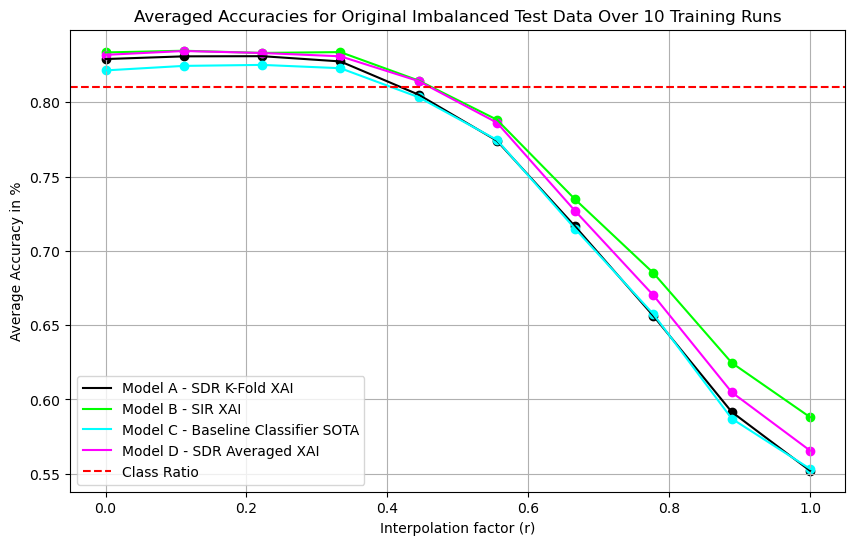

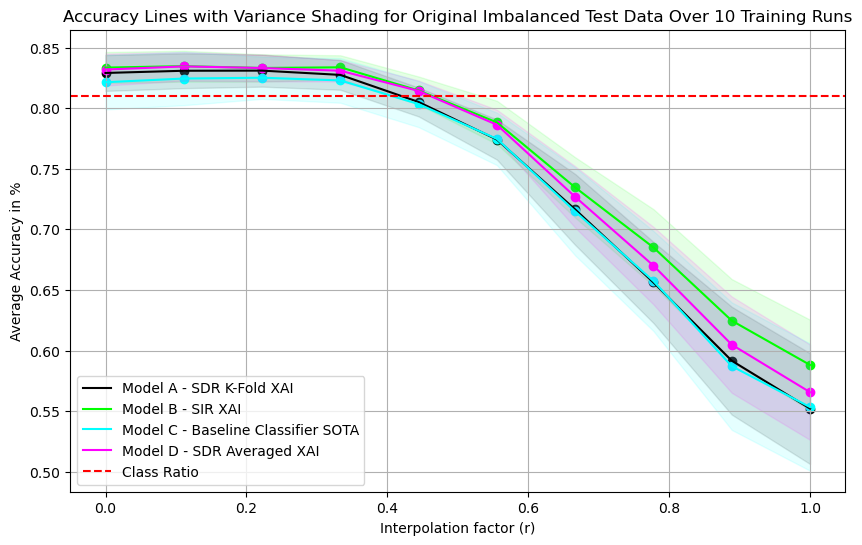

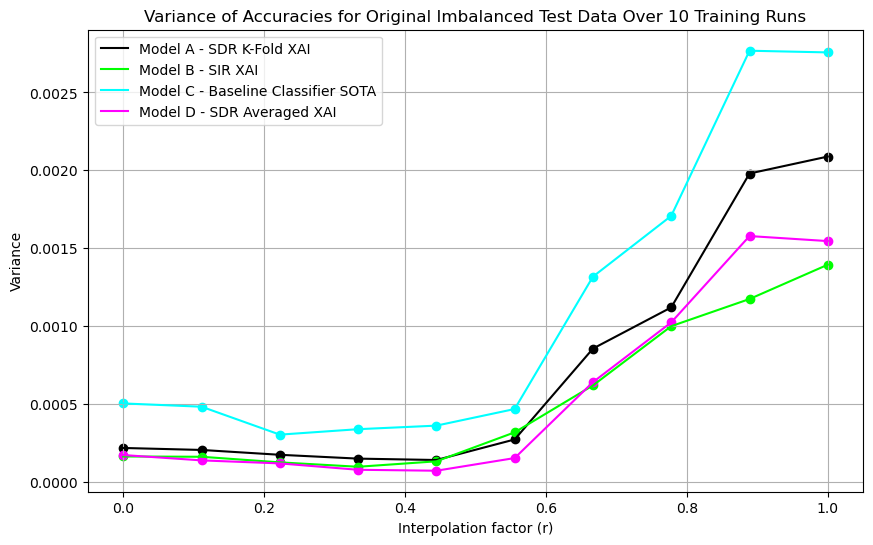

In [258]:
import os
import numpy as np
import torch
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Interpolation with provided noise
def interpolate_with_given_noise(data, r, noise):
    return (1 - r) * data + r * noise

# Evaluation function
def evaluate_model_on_interpolated_data(data, true_labels, model, device, r, noise):
    interpolated_data = interpolate_with_given_noise(data, r, noise)
    interpolated_data = torch.tensor(interpolated_data, dtype=torch.float32).to(device)

    with torch.no_grad():
        predictions = model(interpolated_data)

    predicted_labels = (predictions > 0.5).float().cpu().numpy()
    return accuracy_score(true_labels, predicted_labels)

# Directory containing all model type folders, insert needed folder
base_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new"

# List all model type folders
model_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
print(model_folders)

results = {}
variances = {}
r_values = np.linspace(0, 1, 10)

for r in r_values:
    # Generate noise once for this r-value, so every model gets the same noise
    noise = np.random.randn(*normalized_data.shape)

    for folder in model_folders:
        folder_path = os.path.join(base_dir, folder)

        accuracies = []
        # List all runs for this model type
        run_files = [f for f in os.listdir(folder_path) if f.endswith('.pth')]
        
        for run in run_files:
            model_path = os.path.join(folder_path, run)
            
            # Load the model
            model = Net()
            model.load_state_dict(torch.load(model_path))
            model.eval()
            model.to(device)
            # data type
            accuracy = evaluate_model_on_interpolated_data(normalized_data, test_label, model, device, r, noise)
            accuracies.append(accuracy)
        
        # Store the average accuracy and variance for this r-value in the results
        results.setdefault(folder, []).append(np.mean(accuracies))
        variances.setdefault(folder, []).append(np.var(accuracies))
print(results)
# add majoruty class ratio     
majority_class_ratio = max(np.mean(test_label), 1 - np.mean(test_label))
# Corrected model names mapping
model_names = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'Model A - SDR K-Fold XAI',
    'sir_intensity_total_shap_10_aplha03': 'Model B - SIR XAI',
    'binary_classifier_sota_10': 'Model C - Baseline Classifier SOTA',
    'sdr_average_10_aplha03_1000_l1': 'Model D - SDR Averaged XAI'
}


# Color mapping for the models
color_mapping = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'black',
    'sir_intensity_total_shap_10_aplha03': 'lime',
    'binary_classifier_sota_10': 'cyan',
    'sdr_average_10_aplha03_1000_l1': 'magenta'
}


# Function to get color for a model
def get_model_color(model_name):
    return color_mapping.get(model_name, 'gray')  # Default to 'gray' if model not found

# Plot 1: Just the accuracy lines for each model
plt.figure(figsize=(10, 6))
for model_file_name, accuracies in results.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)  # Use .get() for safe access
    plt.plot(r_values, accuracies, label=label, color=color)
    plt.scatter(r_values, accuracies, color=color)
plt.axhline(y=majority_class_ratio, color='r', linestyle='--', label="Class Ratio")
plt.xlabel("Interpolation factor (r)")
plt.ylabel("Average Accuracy in %")
plt.legend()
plt.grid(True)
plt.title("Averaged Accuracies for Original Imbalanced Test Data Over 10 Training Runs")
plt.show()

# Plot 2: Accuracy lines for each model with the variance shown as the filled space
plt.figure(figsize=(10, 6))
for model_file_name, accuracies in results.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)  # Use .get() for safe access
    std_devs = np.sqrt(variances[model_file_name])
    plt.plot(r_values, accuracies, label=label, color=color)
    plt.scatter(r_values, accuracies, color=color)
    plt.fill_between(r_values, 
                     np.array(accuracies) - std_devs, 
                     np.array(accuracies) + std_devs, 
                     color=color, alpha=0.1)
plt.axhline(y=majority_class_ratio, color='r', linestyle='--', label="Class Ratio")

plt.xlabel("Interpolation factor (r)")
plt.ylabel("Average Accuracy in %")
plt.legend()
plt.grid(True)
plt.title("Accuracy Lines with Variance Shading for Original Imbalanced Test Data Over 10 Training Runs")
plt.show()

# Plot 3: Just the variance lines for each model
plt.figure(figsize=(10, 6))
for model_file_name, variance in variances.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)  # Use .get() for safe access
    plt.plot(r_values, variance, label=label, color=color)
    plt.scatter(r_values, variance, color=color)
plt.xlabel("Interpolation factor (r)")
plt.ylabel("Variance")
plt.legend()
plt.grid(True)
plt.title("Variance of Accuracies for Original Imbalanced Test Data Over 10 Training Runs")
plt.show()
# Convert results to a DataFrame
df_results = pd.DataFrame(results)
df_results['r_value'] = r_values

# Save results to a CSV file
df_results.to_csv(os.path.join(base_dir, 'average_accuracies_imbalanced.csv'), index=False)

# Convert variances to a DataFrame
df_variances = pd.DataFrame(variances)
df_variances['r_value'] = r_values

# Save variances to a CSV file
df_variances.to_csv(os.path.join(base_dir, 'variances_imbalanced.csv'), index=False)



### Accuracy for class balanced test data

['sdr_kfold_shap_10_aplha03_25_1000_l1', 'sir_intensity_total_shap_10_aplha03', 'binary_classifier_sota_10', 'sdr_average_10_aplha03_1000_l1']


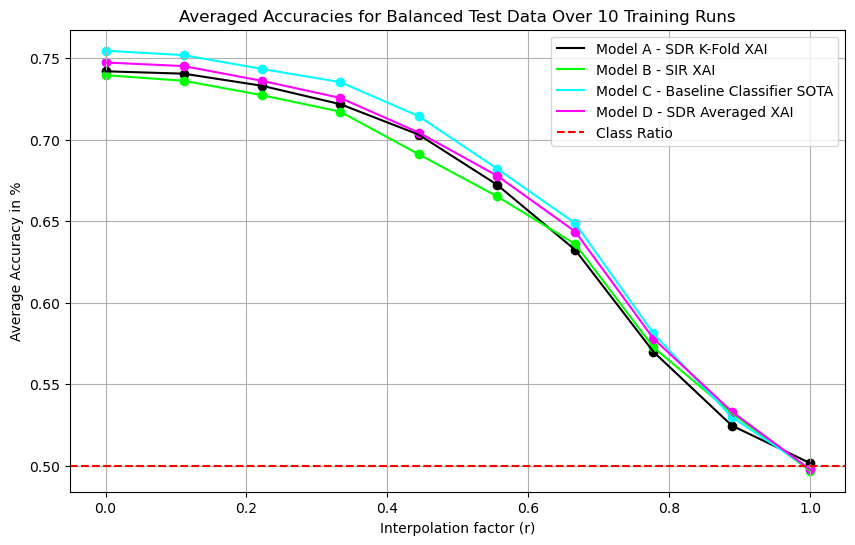

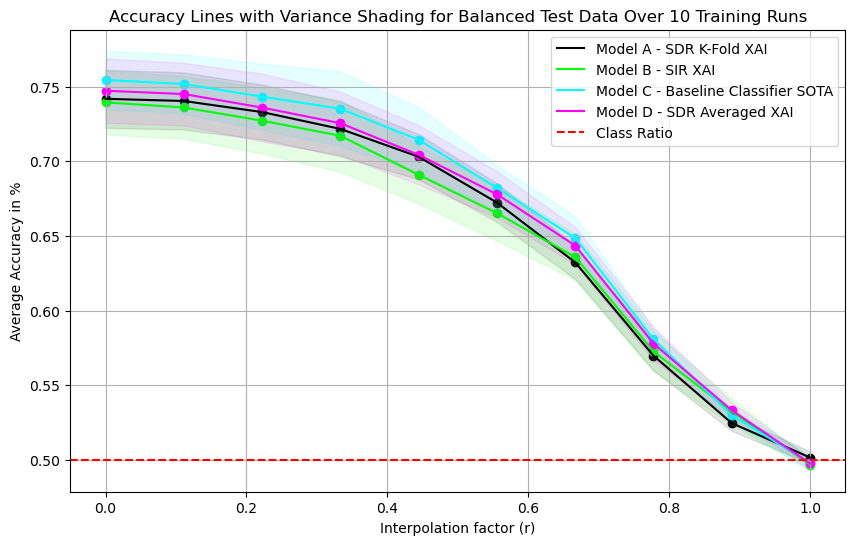

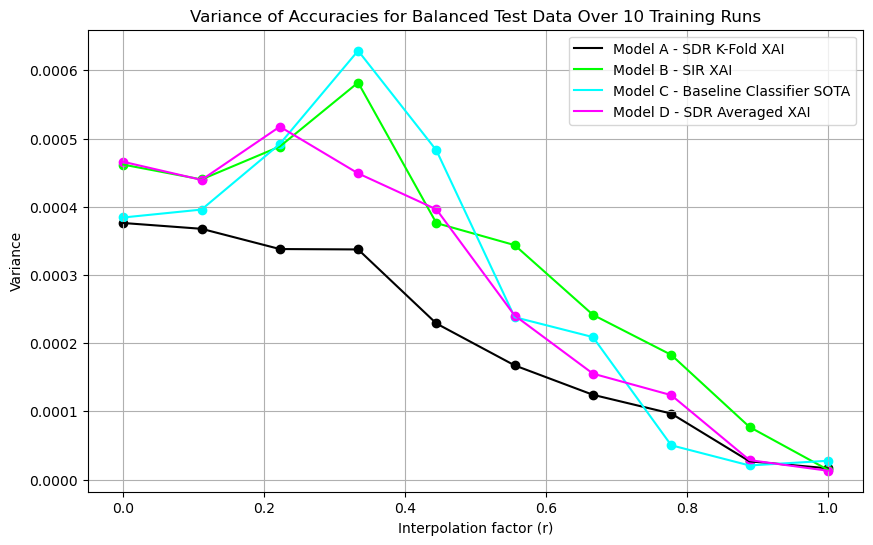

In [257]:
import os
import numpy as np
import torch
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Interpolation with provided noise
def interpolate_with_given_noise(data, r, noise):
    return (1 - r) * data + r * noise

# Evaluation function
def evaluate_model_on_interpolated_data(data, true_labels, model, device, r, noise):
    interpolated_data = interpolate_with_given_noise(data, r, noise)
    interpolated_data = torch.tensor(interpolated_data, dtype=torch.float32).to(device)

    with torch.no_grad():
        predictions = model(interpolated_data)

    predicted_labels = (predictions > 0.5).float().cpu().numpy()
    return accuracy_score(true_labels, predicted_labels)

# Directory containing all model type folders, insert needed folder
base_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new"

# List all model type folders
model_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
print(model_folders)

results = {}
variances = {}
r_values = np.linspace(0, 1, 10)

for r in r_values:
    # Generate noise once for this r-value, so every model gets the same noise
    noise = np.random.randn(*data_resampled.shape)

    for folder in model_folders:
        folder_path = os.path.join(base_dir, folder)

        accuracies = []
        # List all runs for this model type
        run_files = [f for f in os.listdir(folder_path) if f.endswith('.pth')]
        
        for run in run_files:
            model_path = os.path.join(folder_path, run)
            
            # Load the model
            model = Net()
            model.load_state_dict(torch.load(model_path))
            model.eval()
            model.to(device)
            # data type
            accuracy = evaluate_model_on_interpolated_data(data_resampled, label_resampled, model, device, r, noise)
            accuracies.append(accuracy)
        
        # Store the average accuracy and variance for this r-value in the results
        results.setdefault(folder, []).append(np.mean(accuracies))
        variances.setdefault(folder, []).append(np.var(accuracies))

# add majoruty class ratio     
majority_class_ratio = max(np.mean(label_resampled), 1 - np.mean(label_resampled))
# Corrected model names mapping
model_names = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'Model A - SDR K-Fold XAI',
    'sir_intensity_total_shap_10_aplha03': 'Model B - SIR XAI',
    'binary_classifier_sota_10': 'Model C - Baseline Classifier SOTA',
    'sdr_average_10_aplha03_1000_l1': 'Model D - SDR Averaged XAI'
}


# Color mapping for the models
color_mapping = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'black',
    'sir_intensity_total_shap_10_aplha03': 'lime',
    'binary_classifier_sota_10': 'cyan',
    'sdr_average_10_aplha03_1000_l1': 'magenta'
}


# Function to get color for a model
def get_model_color(model_name):
    return color_mapping.get(model_name, 'gray')  # Default to 'gray' if model not found

# Plot 1: Just the accuracy lines for each model with scatter points
plt.figure(figsize=(10, 6))
for model_file_name, accuracies in results.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    plt.plot(r_values, accuracies, label=label, color=color)
    plt.scatter(r_values, accuracies, color=color)  # Add scatter points
plt.axhline(y=majority_class_ratio, color='r', linestyle='--', label="Class Ratio")
plt.xlabel("Interpolation factor (r)")
plt.ylabel("Average Accuracy in %")
plt.legend()
plt.grid(True)
plt.title("Averaged Accuracies for Balanced Test Data Over 10 Training Runs")
plt.show()

# Plot 2: Accuracy lines for each model with the variance shown as the filled space and scatter points
plt.figure(figsize=(10, 6))
for model_file_name, accuracies in results.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    std_devs = np.sqrt(variances[model_file_name])
    plt.plot(r_values, accuracies, label=label, color=color)
    plt.scatter(r_values, accuracies, color=color)  # Add scatter points
    plt.fill_between(r_values, 
                     np.array(accuracies) - std_devs, 
                     np.array(accuracies) + std_devs, 
                     color=color, alpha=0.1)
plt.axhline(y=majority_class_ratio, color='r', linestyle='--', label="Class Ratio")
plt.xlabel("Interpolation factor (r)")
plt.ylabel("Average Accuracy in %")
plt.legend()
plt.grid(True)
plt.title("Accuracy Lines with Variance Shading for Balanced Test Data Over 10 Training Runs")
plt.show()

# Plot 3: Just the variance lines for each model with scatter points
plt.figure(figsize=(10, 6))
for model_file_name, variance in variances.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    plt.plot(r_values, variance, label=label, color=color)
    plt.scatter(r_values, variance, color=color)  # Add scatter points
plt.xlabel("Interpolation factor (r)")
plt.ylabel("Variance")
plt.legend()
plt.grid(True)
plt.title("Variance of Accuracies for Balanced Test Data Over 10 Training Runs")
plt.show()

# Save results and variances to CSV files
df_results = pd.DataFrame(results)
df_results['r_value'] = r_values
df_results.to_csv(os.path.join(base_dir, 'average_accuracies_balanced.csv'), index=False)

df_variances = pd.DataFrame(variances)
df_variances['r_value'] = r_values
df_variances.to_csv(os.path.join(base_dir, 'variances_balanced.csv'), index=False)

# Robustness of an Explanation

## Average Sensitivity 150 first representative samples

In [262]:
import numpy as np
from scipy import stats

print(test_hold.shape)
print(test_label.shape)
data_150= test_label[:150]
data_all = test_label

# flatten the data to make it one-dimensional
data_150_flat = data_150.flatten()
data_all_flat = data_all.flatten()

# Kolmogorov-Smirnov test to compare the distributions _??
ks_statistic, ks_pvalue = stats.ks_2samp(data_150.flat, data_all_flat)

print("Kolmogorov-Smirnov Test:")
print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {ks_pvalue}")


alpha = 0.05  # signifikanz
if ks_pvalue > alpha:
    print("The two datasets are likely drawn from the same distribution.")
else:
    print("The two datasets are likely drawn from different distributions.")


(2695, 256)
(2695,)
Kolmogorov-Smirnov Test:
KS Statistic: 0.0766852195423624
P-value: 0.3546569228558633
The two datasets are likely drawn from the same distribution.


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


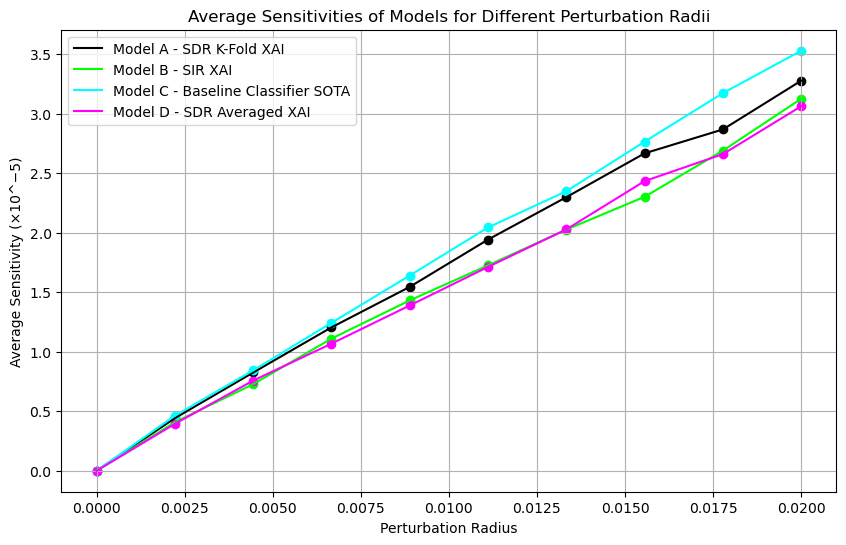

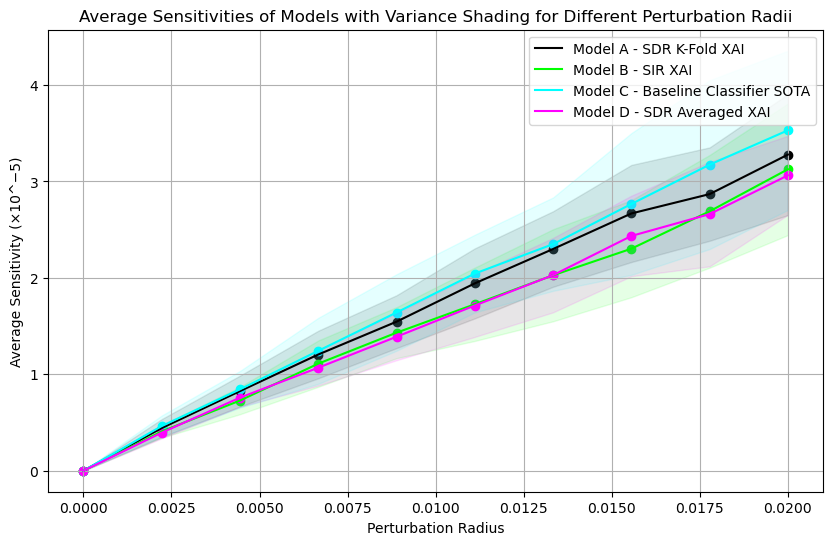

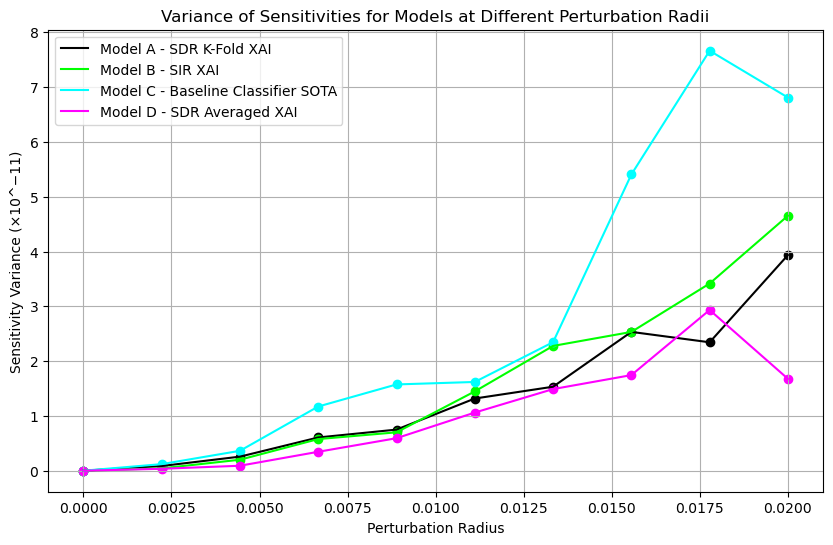

In [221]:
import os
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import shap
import matplotlib.ticker as mticker


def perturb_data(data, perturb_radius=0.1):
    perturbation = (np.random.uniform(-1, 1, data.shape) * perturb_radius).astype(data.dtype)
    return data + perturbation

def create_explainer(model, background_data):
    background_data_tensor = torch.tensor(background_data, dtype=torch.float32).to(device)
    explainer = shap.DeepExplainer(model, background_data_tensor)
    return explainer

def compute_average_sensitivity(model, data, perturb_radius, num_samples=150, background_size=1000):
    random_indices = np.random.choice(len(data), size=background_size, replace=False)
    background_data = data[random_indices]

    explainer = create_explainer(model, background_data)
    
    # first 150 number of samples
    data_subset = data[:num_samples]
    data_tensor = torch.tensor(data_subset, dtype=torch.float32).to(device)

    shap_values_original = explainer.shap_values(data_tensor)
    shap_values_original = np.array(shap_values_original)
    
    # Predictions for the original data
    preds_original = model(data_tensor).detach().cpu().numpy()

    differences = []
    for i in range(num_samples):
        perturbed_data = perturb_data(data_subset[i:i+1], perturb_radius)
        perturbed_data_tensor = torch.tensor(perturbed_data, dtype=torch.float32).to(device)
        
        # Predictions for the perturbed data
        preds_perturbed = model(perturbed_data_tensor).detach().cpu().numpy()
        
        if np.allclose(preds_original[i], preds_perturbed, atol=1e-5):  # Using a small tolerance
            shap_values_perturbed = explainer.shap_values(perturbed_data_tensor)
            shap_values_perturbed = np.array(shap_values_perturbed)
            diff = np.mean(np.abs(shap_values_original[i] - shap_values_perturbed))
            differences.append(diff)
    
    return np.mean(differences)



base_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new"
model_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]

perturb_radii = np.linspace(0, 0.02, 10)
average_sensitivities = {}
average_sensitivities_var = {}

for radius in perturb_radii:
    for folder in model_folders:
        folder_path = os.path.join(base_dir, folder)
        sensitivity_list = []

        run_files = [f for f in os.listdir(folder_path) if f.endswith('.pth')]
        
        for run in run_files:
            model_path = os.path.join(folder_path, run)
            model = Net()
            model.load_state_dict(torch.load(model_path))
            model.eval().to(device)

            sensitivity = compute_average_sensitivity(model, normalized_data, radius)
            sensitivity_list.append(sensitivity)
        
        average_sensitivities.setdefault(folder, []).append(np.mean(sensitivity_list))
        average_sensitivities_var.setdefault(folder, []).append(np.var(sensitivity_list))

df_avg_sensitivities = pd.DataFrame(average_sensitivities)
df_avg_sensitivities['perturb_radius'] = perturb_radii
df_avg_sensitivities.to_csv(os.path.join(base_dir, 'avg_sensitivities_150.csv'), index=False)

df_avg_sensitivities_var = pd.DataFrame(average_sensitivities_var)
df_avg_sensitivities_var['perturb_radius'] = perturb_radii
df_avg_sensitivities_var.to_csv(os.path.join(base_dir, 'avg_sensitivities_var_150.csv'), index=False)

# Use the same color and model names mapping as before
model_names = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'Model A - SDR K-Fold XAI',
    'sir_intensity_total_shap_10_aplha03': 'Model B - SIR XAI',
    'binary_classifier_sota_10': 'Model C - Baseline Classifier SOTA',
    'sdr_average_10_aplha03_1000_l1': 'Model D - SDR Averaged XAI'
}

color_mapping = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'black',
    'sir_intensity_total_shap_10_aplha03': 'lime',
    'binary_classifier_sota_10': 'cyan',
    'sdr_average_10_aplha03_1000_l1': 'magenta'
}

# Function to get color for a model
def get_model_color(model_name):
    return color_mapping.get(model_name, 'gray')  # Default to 'gray' if model not found




def format_ylabel(ax, label):
    # Draw the plot to update the figure and get the latest offset text
    plt.draw()
    scale_factor = ax.yaxis.get_offset_text().get_text()

    # Hide the original offset text
    ax.yaxis.get_offset_text().set_visible(False)

    if scale_factor:
        # Extract the exponent to place it in the ylabel
        exponent = scale_factor.split('e')[-1]
        # Remove unnecessary '+0' from the exponent
        exponent = exponent.replace('+0', '')
        # Append the exponent to the label
        ylabel_with_exponent = f"{label} (×10^{exponent})"
    else:
        ylabel_with_exponent = label

    # Set the formatted ylabel
    ax.set_ylabel(ylabel_with_exponent, fontsize=10)


# Plot 1: Average Sensitivities
plt.figure(figsize=(10, 6))
ax1 = plt.gca()
for model_file_name, sensitivity_values in average_sensitivities.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    plt.plot(perturb_radii, sensitivity_values, label=label, color=color)
    plt.scatter(perturb_radii, sensitivity_values, color=color)  # Add dots
format_ylabel(ax1, "Average Sensitivity")
plt.xlabel("Perturbation Radius")
plt.legend()
plt.grid(True)
plt.title("Average Sensitivities of Models for Different Perturbation Radii")
plt.show()

# Plot 2: Average Sensitivities with Variance Shading
plt.figure(figsize=(10, 6))
ax2 = plt.gca()
for model_file_name, sensitivity_values in average_sensitivities.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    std_devs = np.sqrt(average_sensitivities_var[model_file_name])
    plt.plot(perturb_radii, sensitivity_values, label=label, color=color)
    plt.scatter(perturb_radii, sensitivity_values, color=color)  # Add dots
    plt.fill_between(perturb_radii,
                     np.array(sensitivity_values) - std_devs,
                     np.array(sensitivity_values) + std_devs,
                     color=color, alpha=0.1)
format_ylabel(ax2, "Average Sensitivity")
plt.xlabel("Perturbation Radius")
plt.legend()
plt.grid(True)
plt.title("Average Sensitivities of Models with Variance Shading for Different Perturbation Radii")
plt.show()

# Plot 3: Variance of Sensitivities
plt.figure(figsize=(10, 6))
ax3 = plt.gca()
for model_file_name, sensitivity_values_var in average_sensitivities_var.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    plt.plot(perturb_radii, sensitivity_values_var, label=label, color=color)
    plt.scatter(perturb_radii, sensitivity_values_var, color=color)  # Add dots
format_ylabel(ax3, "Sensitivity Variance")
plt.xlabel("Perturbation Radius")
plt.legend()
plt.grid(True)
plt.title("Variance of Sensitivities for Models at Different Perturbation Radii")
plt.show()

### Avarage Sensitivity for 100 random samples 

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


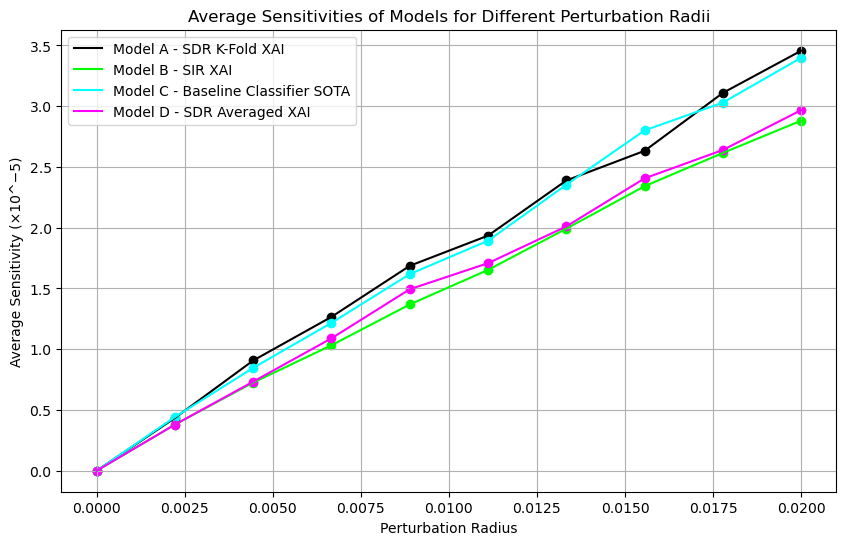

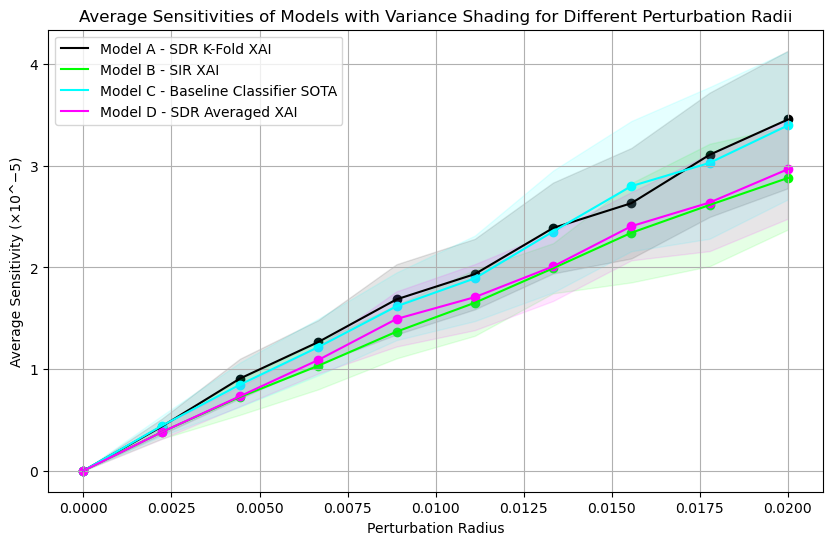

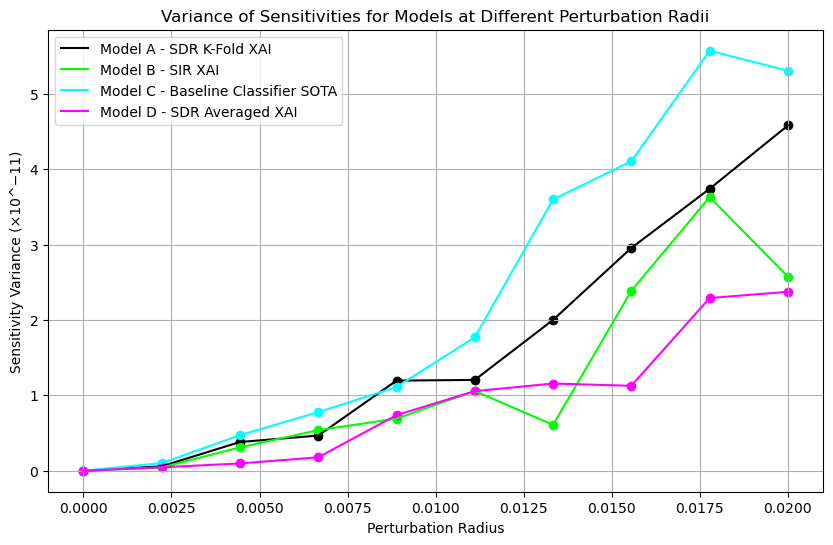

In [225]:
import os
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import shap
import matplotlib.ticker as mticker


def perturb_data(data, perturb_radius=0.1):
    perturbation = (np.random.uniform(-1, 1, data.shape) * perturb_radius).astype(data.dtype)
    return data + perturbation

def create_explainer(model, background_data):
    background_data_tensor = torch.tensor(background_data, dtype=torch.float32).to(device)
    explainer = shap.DeepExplainer(model, background_data_tensor)
    return explainer

def compute_average_sensitivity(model, data, perturb_radius, num_samples=100, background_size=1000):
    random_indices = np.random.choice(len(data), size=background_size, replace=False)
    background_data = data[random_indices]

    explainer = create_explainer(model, background_data)
    
    # 100 random samples
    indices = np.random.choice(len(data), size=num_samples, replace=False)
    data_subset = data[indices]
    data_tensor = torch.tensor(data_subset, dtype=torch.float32).to(device)

    shap_values_original = explainer.shap_values(data_tensor)
    shap_values_original = np.array(shap_values_original)
    
    # Predictions for the original data
    preds_original = model(data_tensor).detach().cpu().numpy()

    differences = []
    for i in range(num_samples):
        perturbed_data = perturb_data(data_subset[i:i+1], perturb_radius)
        perturbed_data_tensor = torch.tensor(perturbed_data, dtype=torch.float32).to(device)
        
        # Predictions for the perturbed data
        preds_perturbed = model(perturbed_data_tensor).detach().cpu().numpy()
        
        if np.allclose(preds_original[i], preds_perturbed, atol=1e-5):  # Using a small tolerance
            shap_values_perturbed = explainer.shap_values(perturbed_data_tensor)
            shap_values_perturbed = np.array(shap_values_perturbed)
            diff = np.mean(np.abs(shap_values_original[i] - shap_values_perturbed))
            differences.append(diff)
    
    return np.mean(differences)



base_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new"
model_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]

perturb_radii = np.linspace(0, 0.02, 10)
average_sensitivities = {}
average_sensitivities_var = {}

for radius in perturb_radii:
    for folder in model_folders:
        folder_path = os.path.join(base_dir, folder)
        sensitivity_list = []

        run_files = [f for f in os.listdir(folder_path) if f.endswith('.pth')]
        
        for run in run_files:
            model_path = os.path.join(folder_path, run)
            model = Net()
            model.load_state_dict(torch.load(model_path))
            model.eval().to(device)

            sensitivity = compute_average_sensitivity(model, normalized_data, radius)
            sensitivity_list.append(sensitivity)
        
        average_sensitivities.setdefault(folder, []).append(np.mean(sensitivity_list))
        average_sensitivities_var.setdefault(folder, []).append(np.var(sensitivity_list))

df_avg_sensitivities = pd.DataFrame(average_sensitivities)
df_avg_sensitivities['perturb_radius'] = perturb_radii
df_avg_sensitivities.to_csv(os.path.join(base_dir, 'avg_sensitivities_100.csv'), index=False)

df_avg_sensitivities_var = pd.DataFrame(average_sensitivities_var)
df_avg_sensitivities_var['perturb_radius'] = perturb_radii
df_avg_sensitivities_var.to_csv(os.path.join(base_dir, 'avg_sensitivities_var_100.csv'), index=False)

# Use the same color and model names mapping as before
model_names = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'Model A - SDR K-Fold XAI',
    'sir_intensity_total_shap_10_aplha03': 'Model B - SIR XAI',
    'binary_classifier_sota_10': 'Model C - Baseline Classifier SOTA',
    'sdr_average_10_aplha03_1000_l1': 'Model D - SDR Averaged XAI'
}

color_mapping = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'black',
    'sir_intensity_total_shap_10_aplha03': 'lime',
    'binary_classifier_sota_10': 'cyan',
    'sdr_average_10_aplha03_1000_l1': 'magenta'
}

# Function to get color for a model
def get_model_color(model_name):
    return color_mapping.get(model_name, 'gray')  # Default to 'gray' if model not found




def format_ylabel(ax, label):
    # Draw the plot to update the figure and get the latest offset text
    plt.draw()
    scale_factor = ax.yaxis.get_offset_text().get_text()

    # Hide the original offset text
    ax.yaxis.get_offset_text().set_visible(False)

    if scale_factor:
        # Extract the exponent to place it in the ylabel
        exponent = scale_factor.split('e')[-1]
        # Remove unnecessary '+0' from the exponent
        exponent = exponent.replace('+0', '')
        # Append the exponent to the label
        ylabel_with_exponent = f"{label} (×10^{exponent})"
    else:
        ylabel_with_exponent = label

    # Set the formatted ylabel
    ax.set_ylabel(ylabel_with_exponent, fontsize=10)


# Plot 1: Average Sensitivities
plt.figure(figsize=(10, 6))
ax1 = plt.gca()
for model_file_name, sensitivity_values in average_sensitivities.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    plt.plot(perturb_radii, sensitivity_values, label=label, color=color)
    plt.scatter(perturb_radii, sensitivity_values, color=color)  # Add dots
format_ylabel(ax1, "Average Sensitivity")
plt.xlabel("Perturbation Radius")
plt.legend()
plt.grid(True)
plt.title("Average Sensitivities of Models for Different Perturbation Radii")
plt.show()

# Plot 2: Average Sensitivities with Variance Shading
plt.figure(figsize=(10, 6))
ax2 = plt.gca()
for model_file_name, sensitivity_values in average_sensitivities.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    std_devs = np.sqrt(average_sensitivities_var[model_file_name])
    plt.plot(perturb_radii, sensitivity_values, label=label, color=color)
    plt.scatter(perturb_radii, sensitivity_values, color=color)  # Add dots
    plt.fill_between(perturb_radii,
                     np.array(sensitivity_values) - std_devs,
                     np.array(sensitivity_values) + std_devs,
                     color=color, alpha=0.1)
format_ylabel(ax2, "Average Sensitivity")
plt.xlabel("Perturbation Radius")
plt.legend()
plt.grid(True)
plt.title("Average Sensitivities of Models with Variance Shading for Different Perturbation Radii")
plt.show()

# Plot 3: Variance of Sensitivities
plt.figure(figsize=(10, 6))
ax3 = plt.gca()
for model_file_name, sensitivity_values_var in average_sensitivities_var.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    plt.plot(perturb_radii, sensitivity_values_var, label=label, color=color)
    plt.scatter(perturb_radii, sensitivity_values_var, color=color)  # Add dots
format_ylabel(ax3, "Sensitivity Variance")
plt.xlabel("Perturbation Radius")
plt.legend()
plt.grid(True)
plt.title("Variance of Sensitivities for Models at Different Perturbation Radii")
plt.show()

## Other Performance Metrics

In [228]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


def get_predictions_and_probs(model, data):
    # Convert data to a tensor if it's not already one
    if not isinstance(data, torch.Tensor):
        data = torch.Tensor(data)
    
    # Move data to the same device as the model
    data = data.to(device)
    
    model.eval()
    with torch.no_grad():
        logits = model(data)
        probabilities = torch.sigmoid(logits)
    
    predicted_labels = (probabilities > 0.5).float().cpu().numpy()
    predicted_probs = probabilities.cpu().numpy().squeeze()

    return predicted_labels, predicted_probs

def get_metrics_averaged_by_model_type(model_folders, test_data, test_label):
    metrics_by_model_type = {}

    for folder in model_folders:
        folder_path = os.path.join(base_dir, folder)

        accuracies = []
        # List all runs for this model type
        run_files = [f for f in os.listdir(folder_path) if f.endswith('.pth')]
        
        for run in run_files:
            model_path = os.path.join(folder_path, run)
            
            # Load the model
            model = Net()
            model.load_state_dict(torch.load(model_path))
            model.eval()
            model.to(device)
            
            predicted_labels, predicted_probs = get_predictions_and_probs(model, test_data)
            
            precision = precision_score(test_label, predicted_labels)
            recall = recall_score(test_label, predicted_labels)
            f1 = f1_score(test_label, predicted_labels)
            roc_auc = roc_auc_score(test_label, predicted_probs)
            
            metrics = {
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "roc_auc": roc_auc
            }
            
            accuracies.append(metrics)
        
        metrics_by_model_type[folder] = {
            "precision": np.mean([metrics["precision"] for metrics in accuracies]),
            "recall": np.mean([metrics["recall"] for metrics in accuracies]),
            "f1": np.mean([metrics["f1"] for metrics in accuracies]),
            "roc_auc": np.mean([metrics["roc_auc"] for metrics in accuracies])
        }

    return metrics_by_model_type


In [229]:
# Directory containing all model type folders
base_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new"


# Get a list of all folders
model_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]

metrics_by_model_type = get_metrics_averaged_by_model_type(model_folders, normalized_data, test_label)
print(metrics_by_model_type)


{'sdr_kfold_shap_10_aplha03_25_1000_l1': {'precision': 0.28558345787926415, 'recall': 0.975, 'f1': 0.44072671758550586, 'roc_auc': 0.8605526457999313}, 'sir_intensity_total_shap_10_aplha03': {'precision': 0.29997026429044105, 'recall': 0.962890625, 'f1': 0.455461579967935, 'roc_auc': 0.8557853387683234}, 'binary_classifier_sota_10': {'precision': 0.26636587571638065, 'recall': 0.9927734375, 'f1': 0.41808611257325234, 'roc_auc': 0.8735711678309667}, 'sdr_average_10_aplha03_1000_l1': {'precision': 0.2840957909955061, 'recall': 0.9802734375, 'f1': 0.4380180360462508, 'roc_auc': 0.8641099637110627}}


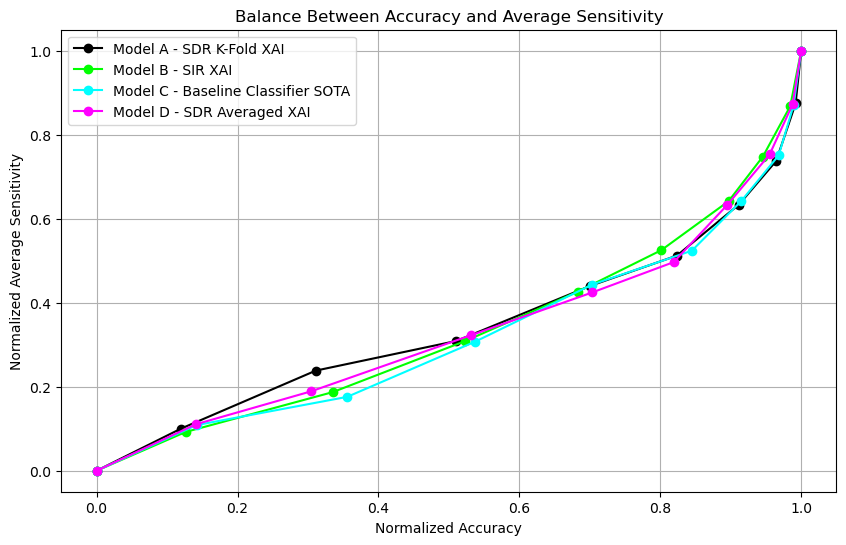

In [255]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load the data
df_accuracy = pd.read_csv('/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new/average_accuracies_balanced.csv')
df_sensitivity = pd.read_csv('/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new/avg_sensitivities_100.csv')



# Normalize the data
scaler = MinMaxScaler()
df_accuracy_normalized = scaler.fit_transform(df_accuracy.drop(['r_value'], axis=1))
df_sensitivity_normalized = 1 - scaler.fit_transform(df_sensitivity.drop(['perturb_radius'], axis=1))

# Adding normalized data back to the dataframes
df_accuracy[df_accuracy.columns[:-1]] = df_accuracy_normalized  # Exclude the 'r_value' column
df_sensitivity[df_sensitivity.columns[:-1]] = df_sensitivity_normalized  # Exclude the 'perturb_radius' column

# Merge dataframes by index
df_merged = pd.merge(df_accuracy, df_sensitivity, left_index=True, right_index=True)

# Plotting
plt.figure(figsize=(10, 6))

# Use the model names and color mapping
for model_key in model_names.keys():
    plt.plot(
        df_merged[model_key + '_x'], 
        df_merged[model_key + '_y'], 
        label=model_names[model_key], 
        color=get_model_color(model_key), 
        marker='o'
    )

plt.xlabel('Normalized Accuracy')
plt.ylabel('Normalized Average Sensitivity')
plt.title('Balance Between Accuracy and Average Sensitivity')
plt.legend()
plt.grid(True)
plt.show()


In [278]:
import os
import numpy as np
import torch
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import shap



def perturb_data(data, perturb_radius=0.1):
    perturbation = (np.random.uniform(-1, 1, data.shape) * perturb_radius).astype(data.dtype)
    return data + perturbation

def create_explainer(model, background_data):
    background_data_tensor = torch.tensor(background_data, dtype=torch.float32).to(device)
    explainer = shap.DeepExplainer(model, background_data_tensor)
    return explainer

def compute_average_sensitivity(model, data, indices, perturb_radius, device):
    data_subset = data[indices]
    data_tensor = torch.tensor(data_subset, dtype=torch.float32).to(device)

    explainer = create_explainer(model, data_tensor)

    shap_values_original = explainer.shap_values(data_tensor)
    shap_values_original = np.array(shap_values_original)
    
    preds_original = model(data_tensor).detach().cpu().numpy()
    differences = []

    for i in range(len(data_subset)):
        perturbed_data = perturb_data(data_subset[i:i+1], perturb_radius)
        perturbed_data_tensor = torch.tensor(perturbed_data, dtype=torch.float32).to(device)
        
        preds_perturbed = model(perturbed_data_tensor).detach().cpu().numpy()
        
        if np.allclose(preds_original[i], preds_perturbed, atol=1e-5):
            shap_values_perturbed = explainer.shap_values(perturbed_data_tensor)
            shap_values_perturbed = np.array(shap_values_perturbed)
            diff = np.mean(np.abs(shap_values_original[i] - shap_values_perturbed))
            differences.append(diff)
    
    return np.mean(differences)

def evaluate_model_on_interpolated_data(data, labels, model, device, r, noise, indices):
    data_subset = data[indices]
    labels_subset = labels[indices]

    interpolated_data = (1 - r) * data_subset + r * noise
    interpolated_data_tensor = torch.tensor(interpolated_data, dtype=torch.float32).to(device)

    with torch.no_grad():
        predictions = model(interpolated_data_tensor)

    predicted_labels = (predictions > 0.5).float().cpu().numpy()
    return accuracy_score(labels_subset, predicted_labels)

# Directory paths and model_folders setup
base_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new"
model_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]

# Generate a single set of random indices for both analyses
random_indices = np.random.choice(len(normalized_data), size=100, replace=False)

# Sensitivity and accuracy evaluation
perturb_radii = np.linspace(0, 0.02, 10)
average_sensitivities = {}
average_sensitivities_var = {}
accuracy_results = {}

for radius in perturb_radii:
    for folder in model_folders:
        folder_path = os.path.join(base_dir, folder)
        sensitivity_list = []
        accuracy_list = []

        run_files = [f for f in os.listdir(folder_path) if f.endswith('.pth')]
        
        for run in run_files:
            model_path = os.path.join(folder_path, run)
            model = Net()
            model.load_state_dict(torch.load(model_path))
            model.eval().to(device)

            sensitivity = compute_average_sensitivity(model, normalized_data, random_indices, radius, device)
            sensitivity_list.append(sensitivity)

            # Generate noise once for the radius, so every model gets the same noise
            noise = np.random.randn(*normalized_data.shape)

            accuracy = evaluate_model_on_interpolated_data(normalized_data, test_label, model, device, radius, noise, random_indices)
            accuracy_list.append(accuracy)
        
        average_sensitivities.setdefault(folder, []).append(np.mean(sensitivity_list))
        average_sensitivities_var.setdefault(folder, []).append(np.var(sensitivity_list))
        accuracy_results.setdefault(folder, []).append(np.mean(accuracy_list))

import os
import numpy as np
import torch
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import shap

# Assuming that necessary functions and the Net model class are already defined

def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

base_dir = "/path/to/your/model/directory"  # Replace with your actual directory
model_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
random_indices = np.random.choice(len(normalized_data), size=100, replace=False)

average_sensitivities = {}
average_accuracies = {}
normalized_accuracy_results = {}
normalized_sensitivity_results = {}

perturb_radii = np.linspace(0, 0.02, 10)
for radius in perturb_radii:
    for folder in model_folders:
        folder_path = os.path.join(base_dir, folder)
        sensitivity_list = []
        accuracy_list = []

        run_files = [f for f in os.listdir(folder_path) if f.endswith('.pth')]
        for run_file in run_files:
            model_path = os.path.join(folder_path, run_file)
            model = Net()  # Your model class
            model.load_state_dict(torch.load(model_path))
            model.eval().to(device)  # Replace 'device' with your device configuration

            # Select the same subset for sensitivity and accuracy evaluations
            data_subset = normalized_data[random_indices]
            labels_subset = test_label[random_indices]

            sensitivity = compute_average_sensitivity(model, data_subset, random_indices, radius, device)
            sensitivity_list.append(sensitivity)

            # Generate noise for each radius, matching the shape of data_subset
            noise = np.random.randn(*data_subset.shape)

            accuracy = evaluate_model_on_interpolated_data(data_subset, labels_subset, model, device, radius, noise, random_indices)
            accuracy_list.append(accuracy)

        average_sensitivities.setdefault(folder, []).append(np.mean(sensitivity_list))
        average_accuracies.setdefault(folder, []).append(np.mean(accuracy_list))


for folder in model_folders:
    normalized_accuracy_results[folder] = normalize(np.array(average_accuracies[folder]))
    normalized_sensitivity_results[folder] = normalize(np.array(average_sensitivities[folder]))

# Model names and color mappings
model_names = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'Model A - SDR K-Fold XAI',
    'sir_intensity_total_shap_10_aplha03': 'Model B - SIR XAI',
    'binary_classifier_sota_10': 'Model C - Baseline Classifier SOTA',
    'sdr_average_10_aplha03_1000_l1': 'Model D - SDR Averaged XAI'
}

color_mapping = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'black',
    'sir_intensity_total_shap_10_aplha03': 'lime',
    'binary_classifier_sota_10': 'cyan',
    'sdr_average_10_aplha03_1000_l1': 'magenta'
}

def get_model_color(model_folder):
    return color_mapping.get(model_folder, 'gray')

plt.figure(figsize=(10, 6))
for folder in model_folders:
    color = get_model_color(folder)
    model_label = model_names.get(folder, folder)
    normalized_accuracies = normalized_accuracy_results[folder]
    normalized_sensitivities = normalized_sensitivity_results[folder]

    plt.scatter(normalized_accuracies, normalized_sensitivities, color=color, alpha=0.7, label=model_label)

plt.xlabel('Normalized Accuracy')
plt.ylabel('Normalized Sensitivity')
plt.title('Tradeoff Between Normalized Accuracy and Sensitivity Across Models')
plt.legend()
plt.grid(True)
plt.show()


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ValueError: operands could not be broadcast together with shapes (100,256) (2695,256) 

In [252]:
def calculate_composite_score(normalized_accuracy, normalized_sensitivity, weight_accuracy, weight_sensitivity):
    """
    Calculate the composite score based on weighted accuracy and sensitivity.
    
    :param normalized_accuracy: DataFrame or Series with normalized accuracy scores.
    :param normalized_sensitivity: DataFrame or Series with normalized sensitivity scores.
    :param weight_accuracy: The weight for the accuracy score.
    :param weight_sensitivity: The weight for the sensitivity score.
    :return: DataFrame or Series with composite scores.
    """
    # Inverting the sensitivity score so that lower sensitivity contributes more positively
    inverted_sensitivity = 1 - normalized_sensitivity
    return (normalized_accuracy * weight_accuracy) + (inverted_sensitivity * weight_sensitivity)

# Example of using the function with your data
weight_accuracy = 0.67
weight_sensitivity = 0.33

# Assuming df_accuracy_normalized and df_sensitivity_normalized are already defined
composite_scores = calculate_composite_score(df_accuracy_normalized, df_sensitivity_normalized, weight_accuracy, weight_sensitivity)

# Displaying the composite scores
print(composite_scores.head())


   sdr_kfold_shap_10_aplha03_25_1000_l1  sir_intensity_total_shap_10_aplha03  \
0                              1.000000                             1.000000   
1                              0.953261                             0.946085   
2                              0.889619                             0.880466   
3                              0.819901                             0.812635   
4                              0.720761                             0.710195   

   binary_classifier_sota_10  sdr_average_10_aplha03_1000_l1  
0                   1.000000                        1.000000  
1                   0.949881                        0.949576  
2                   0.896378                        0.888447  
3                   0.824867                        0.808510  
4                   0.738979                        0.712647  


In [266]:
import torch
# Load the model
model = Net()  # Initialize the model
model_path = '/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new/sdr_kfold_shap_10_aplha03_25_1000_l1/model_run_representatvie_compare2.pth'
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode


Net(
  (network): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

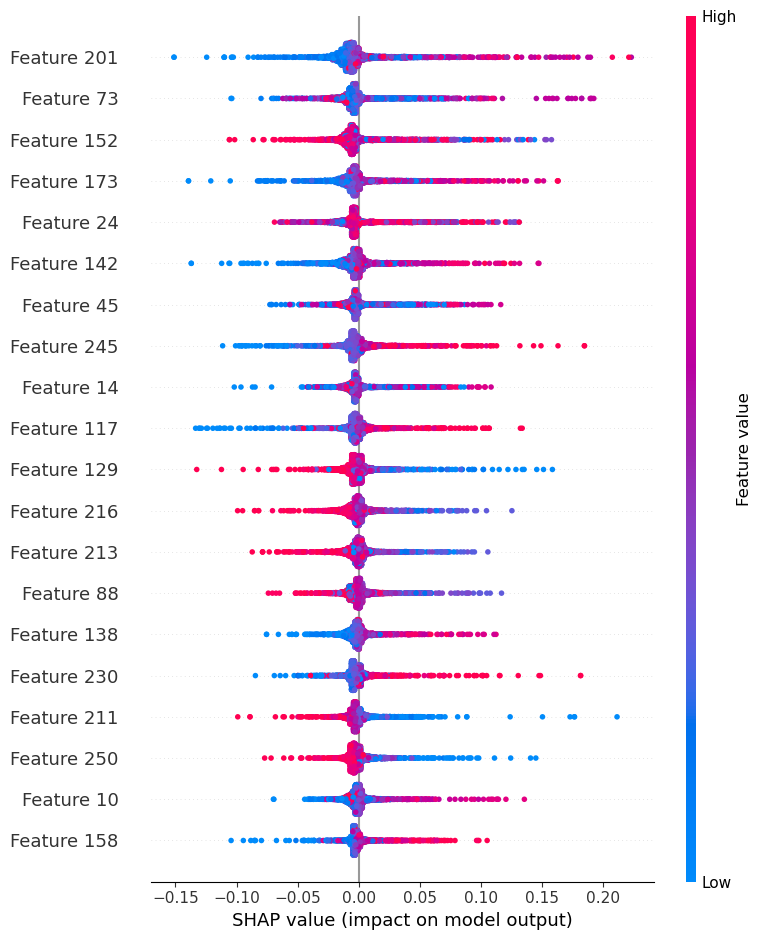

In [272]:
import torch
import numpy as np
import shap

# Load the model
model = Net()  # Replace Net() with your actual model class
model_path = '/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new/sdr_average_10_aplha03_1000_l1/model_run_avg_compare3.pth'
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Assume 'data' is your full dataset and 'test_hold' is your test set
# Ensure 'data' is in the correct format as expected by your model

# Select a random subset of your data as background data for SHAP
random_indices = np.random.choice(len(data), size=1000, replace=False)
background_data = data[random_indices]

# Convert background data to PyTorch tensor
background_data_tensor = torch.tensor(background_data, dtype=torch.float32)  # Add .to(device) if using GPU

# Create a SHAP explainer using the model and background data tensor
explainer = shap.DeepExplainer(model, background_data_tensor)

# Convert test set to PyTorch tensor
test_hold_tensor = torch.tensor(test_hold, dtype=torch.float32)  # Add .to(device) if using GPU

# Compute SHAP values for the test set
shap_values_test = explainer.shap_values(test_hold_tensor)

# Plot the SHAP values
# Convert test_hold_tensor to numpy array if needed for plotting
shap.summary_plot(shap_values_test, test_hold_tensor.cpu().numpy())
